In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

from qtrendutils import mapplot_utils as mymaps
from qtrendutils import colorbar_utils as cbars
from qtrendutils import calendar_utils as cal
from qtrendutils import linfit_utils as linfit

plt.rc('font', family='Arial')

import sys

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

### Read in the land fraction

In [3]:
landfrac = xr.open_dataset("/project/cas/islas/cesm2le/fx/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = landfrac.where(landfrac > 0, nan)

### Read in the CMIP6 global vp and pr trends

In [4]:
vpglobal = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2014_trends/vptrends_CMIP6.nc").vp
vpglobal['lon'] = landfrac.lon ; vpglobal['lat'] = landfrac.lat
prglobal = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2014_trends/prtrends_CMIP6.nc").pr
prglobal['lon'] = landfrac.lon ; prglobal['lat'] = landfrac.lat

vpglobal_stacked = vpglobal.stack(z=("model","member"))
prglobal_stacked = prglobal.stack(z=("model","member"))

testpoint = vpglobal_stacked.isel(lon=0, lat=0)
vpglobal_stacked = vpglobal_stacked.where( ~np.isnan(testpoint), drop=True)
prglobal_stacked = prglobal_stacked.where( ~np.isnan(testpoint), drop=True)

### Read in the AMIP6 global vp and pr trends

In [5]:
vpglobal_amip = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2014_trends/vptrends_AMIP6.nc").vp
vpglobal_amip['lon'] = landfrac.lon ; vpglobal_amip['lat'] = landfrac.lat
prglobal_amip = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2014_trends/prtrends_AMIP6.nc").pr
prglobal_amip['lon'] = landfrac.lon ; prglobal_amip['lat'] = landfrac.lat

vpglobal_amip_stacked = vpglobal_amip.stack(z=("model","member"))
prglobal_amip_stacked = prglobal_amip.stack(z=("model","member"))

testpoint = vpglobal_amip_stacked.isel(lon=0, lat=0)
vpglobal_amip_stacked = vpglobal_amip_stacked.where( ~np.isnan(testpoint), drop=True)
prglobal_amip_stacked = prglobal_amip_stacked.where( ~np.isnan(testpoint), drop=True)

### Read in the GPCP precipitation trends

In [6]:
gpcc_global = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2014_trends/prtrends_GPCC.nc").pr
gpcc_global['lon'] = landfrac.lon ; gpcc_global['lat'] = landfrac.lat

#---setting the grid points that are identically zero to nan's because it was causing a plotting issue
gpcc_global = gpcc_global.where(gpcc_global != 0, nan)

In [7]:
era5_global = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2014_trends/vptrends_ERA5.nc").vp
era5_global['lon'] = landfrac.lon ; era5_global['lat'] = landfrac.lat

### Ensemble means

In [8]:
prglobal_amip_memmean = prglobal_amip.mean('member')
prglobal_amip_modelmean = prglobal_amip_memmean.mean('model')

vpglobal_amip_memmean = vpglobal_amip.mean('member')
vpglobal_amip_modelmean = vpglobal_amip_memmean.mean('model')

prglobal_memmean = prglobal.mean('member')
prglobal_modelmean = prglobal_memmean.mean('model')

vpglobal_memmean = vpglobal.mean('member')
vpglobal_modelmean = vpglobal_memmean.mean('model')

### Work out the deviations of ERA5 from the CMIP6 relation with precipitation (using all models and all members)

In [9]:
cmip6vp_map = vpglobal.stack(z=['model','member'])
cmip6pr_map = prglobal.stack(z=['model','member'])*86400.

testpoint = cmip6vp_map.sel(lon=180, lat=0, method='nearest')
cmip6vp_map = cmip6vp_map.where(~np.isnan(testpoint), drop=True)
cmip6pr_map = cmip6pr_map.where(~np.isnan(testpoint), drop=True)

aglobal = np.zeros([cmip6pr_map.lat.size, cmip6pr_map.lon.size]) ; bglobal = np.zeros([cmip6pr_map.lat.size, cmip6pr_map.lon.size])
aglobal[:,:] = nan ; bglobal[:,:] = nan

for ilon in np.arange(0,cmip6pr_map.lon.size,1):
    for ilat in np.arange(0,cmip6pr_map.lat.size,1):
        if (landfrac[ilat,ilon] == 1):
            a_t, b_t = linfit.linfit_xy(cmip6pr_map.isel(lon=ilon,lat=ilat), cmip6vp_map.isel(lon=ilon, lat=ilat))
            aglobal[ilat,ilon] = a_t ; bglobal[ilat,ilon] = b_t
            
aglobal = xr.DataArray(aglobal, coords=[cmip6pr_map.lat, cmip6pr_map.lon], dims=['lat','lon'], name='aglobal')
bglobal = xr.DataArray(bglobal, coords=[cmip6pr_map.lat, cmip6pr_map.lon], dims=['lat','lon'], name='bglobal')

vppredict = aglobal + bglobal*cmip6pr_map
residuals = cmip6vp_map - vppredict
residualstdev = residuals.std(dim='z')

vppredict_gpcc = aglobal + bglobal*gpcc_global
era5vptrenddif_gpcc = era5_global - np.array(vppredict_gpcc)
vpshading_after_gpcc = era5_global*nan
vpshading_after_gpcc = vpshading_after_gpcc.where( (era5vptrenddif_gpcc > 2*residualstdev) | (era5vptrenddif_gpcc < -2*residualstdev), 1)
vpshading_after_gpcc = vpshading_after_gpcc.where( np.array(landfrac) > 0, nan)

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


### Work out the deviations of ERA5 from the AMIP6 relation with precipitation (using all models and all members)

In [10]:
amip6vp_map = vpglobal_amip.stack(z=['model','member'])
amip6pr_map = prglobal_amip.stack(z=['model','member'])*86400.

testpoint = amip6vp_map.sel(lon=180, lat=0, method='nearest')
amip6vp_map = amip6vp_map.where(~np.isnan(testpoint), drop=True)
amip6pr_map = amip6pr_map.where(~np.isnan(testpoint), drop=True)

aglobal = np.zeros([amip6pr_map.lat.size, amip6pr_map.lon.size]) ; bglobal = np.zeros([amip6pr_map.lat.size, amip6pr_map.lon.size])
aglobal[:,:] = nan ; bglobal[:,:] = nan

for ilon in np.arange(0,amip6pr_map.lon.size,1):
    for ilat in np.arange(0,amip6pr_map.lat.size,1):
        if (landfrac[ilat,ilon] == 1):
            a_t, b_t = linfit.linfit_xy(amip6pr_map.isel(lon=ilon,lat=ilat), amip6vp_map.isel(lon=ilon, lat=ilat))
            aglobal[ilat,ilon] = a_t ; bglobal[ilat,ilon] = b_t
            
aglobal = xr.DataArray(aglobal, coords=[amip6pr_map.lat, amip6pr_map.lon], dims=['lat','lon'], name='aglobal')
bglobal = xr.DataArray(bglobal, coords=[amip6pr_map.lat, amip6pr_map.lon], dims=['lat','lon'], name='bglobal')

vppredict = aglobal + bglobal*amip6pr_map
residuals = amip6vp_map - vppredict
residualstdev = residuals.std(dim='z')

vppredict_gpcc_amip = aglobal + bglobal*gpcc_global
era5vptrenddif_gpcc_amip = era5_global - np.array(vppredict_gpcc_amip)
vpshading_after_gpcc_amip = era5_global*nan
vpshading_after_gpcc_amip = vpshading_after_gpcc_amip.where( (era5vptrenddif_gpcc_amip > 2*residualstdev) | (era5vptrenddif_gpcc_amip < -2*residualstdev), 1)
vpshading_after_gpcc_amip = vpshading_after_gpcc_amip.where( np.array(landfrac) > 0, nan)

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


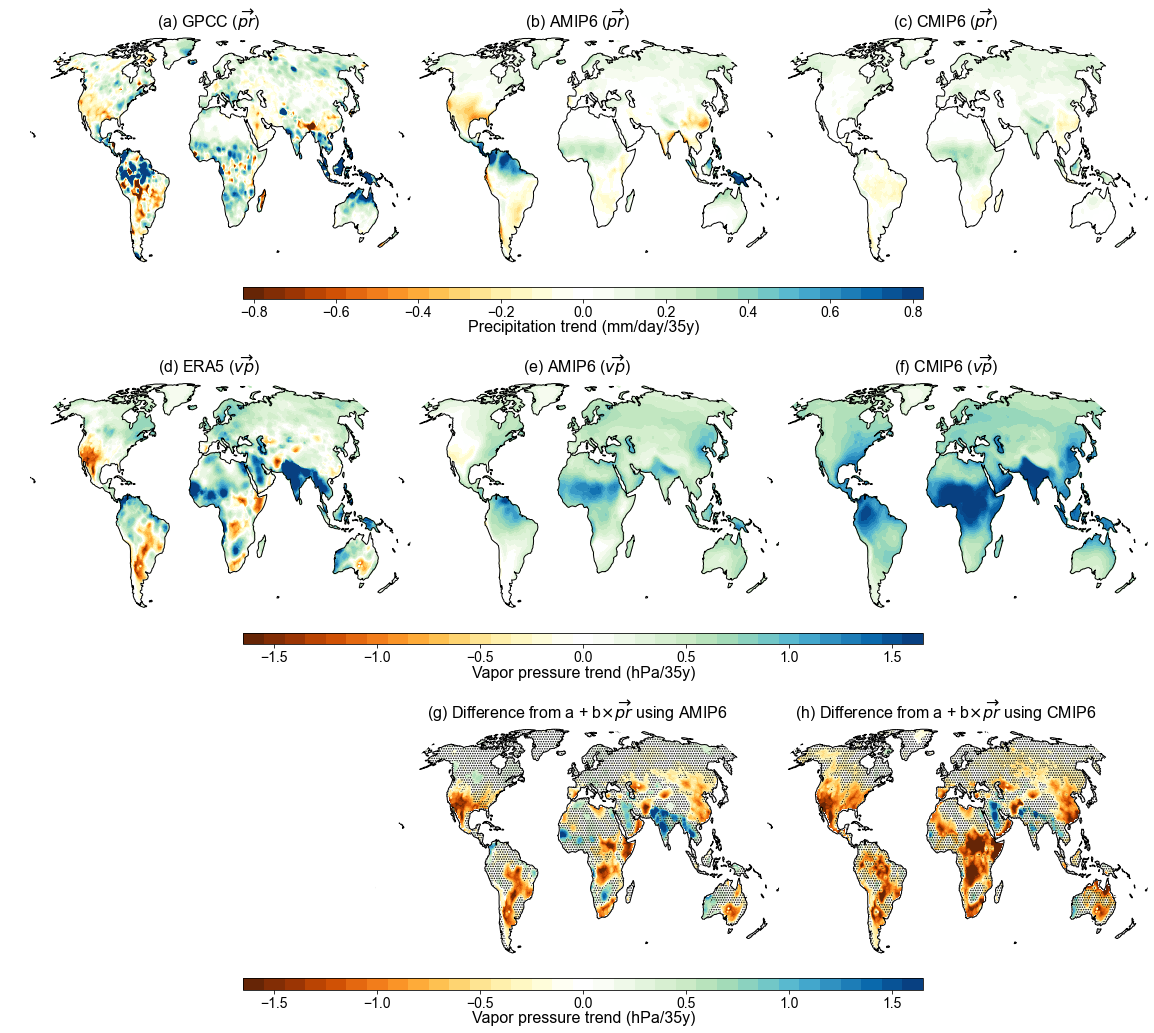

In [11]:
fig = plt.figure(figsize=(16,16))

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, gpcc_global*landfrac, gpcc_global.lon, gpcc_global.lat,
                                                            0.05,-0.8,0.8,'(a) GPCC ($\overrightarrow{pr}$)',0,0.35,0.75,0.95,cmap='precip', fontsize=16)

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, prglobal_amip_modelmean*landfrac, prglobal_amip_modelmean.lon, prglobal_amip_modelmean.lat,
                                                            0.05,-0.8,0.8,'(b) AMIP6 ($\overrightarrow{pr}$)',0.32,0.67,0.75,0.95,cmap='precip', fontsize=16)

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, 86400.*prglobal_modelmean*landfrac, prglobal_modelmean.lon, prglobal_modelmean.lat,
                                                            0.05,-0.8,0.8,'(c) CMIP6 ($\overrightarrow{pr}$)',0.64,0.99,0.75,0.95,cmap='precip', fontsize=16)

ax = cbars.plotcolorbar(fig, 0.05,-0.8,0.8,'Precipitation trend (mm/day/35y)',0.205,0.795,0.72,0.73,cmap='precip')



ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5_global*landfrac, era5_global.lon, era5_global.lat,
                                                            0.1,-1.6,1.6,'(d) ERA5 ($\overrightarrow{vp}$)',0,0.35,0.45,0.65,cmap='precip', fontsize=16)

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, vpglobal_amip_modelmean*landfrac, vpglobal_amip_modelmean.lon, vpglobal_amip_modelmean.lat,
                                                            0.1,-1.6,1.6,'(e) AMIP6 ($\overrightarrow{vp}$)',0.32,0.67,0.45,0.65,cmap='precip', fontsize=16)

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, vpglobal_modelmean*landfrac, vpglobal_modelmean.lon, vpglobal_modelmean.lat,
                                                            0.1,-1.6,1.6,'(f) CMIP6 ($\overrightarrow{vp}$)',0.64,0.99,0.45,0.65,cmap='precip', fontsize=16)

ax = cbars.plotcolorbar(fig, 0.1, -1.6, 1.6, 'Vapor pressure trend (hPa/35y)',0.205,0.795,0.42,0.43,cmap='precip')


ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5vptrenddif_gpcc_amip*np.array(landfrac), era5_global.lon, era5_global.lat,0.1,-1.6,1.6,
                                                            '(g) Difference from a + b$\\times \overrightarrow{pr}$ using AMIP6',
                                                            0.32,0.67,0.15,0.35,cmap='precip', signifdat=vpshading_after_gpcc_amip, stipplesignif=True, fontsize=16)


ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5vptrenddif_gpcc*np.array(landfrac), era5_global.lon, era5_global.lat,0.1,-1.6,1.6,
                                                            '(h) Difference from a + b$\\times \overrightarrow{pr}$ using CMIP6',
                                                            0.64,0.99,0.15,0.35,cmap='precip', signifdat=vpshading_after_gpcc, stipplesignif=True, fontsize=16)

ax = cbars.plotcolorbar(fig, 0.1, -1.6,1.6, 'Vapor pressure trend (hPa/35y)',0.205,0.795,0.12,0.13,cmap='precip')

#fig.savefig(plotpath+'amip_maps.png', bbox_inches='tight', facecolor='white')
fig.savefig(plotpath+'figS12.pdf', bbox_inches='tight', facecolor='white')